# 1. Imports

In [73]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
import math
import joblib
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import time

import FindingBestProfile2 as fbp


# 2. Data Visualisation, Preprocessing, and Feature Engineering

In [74]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


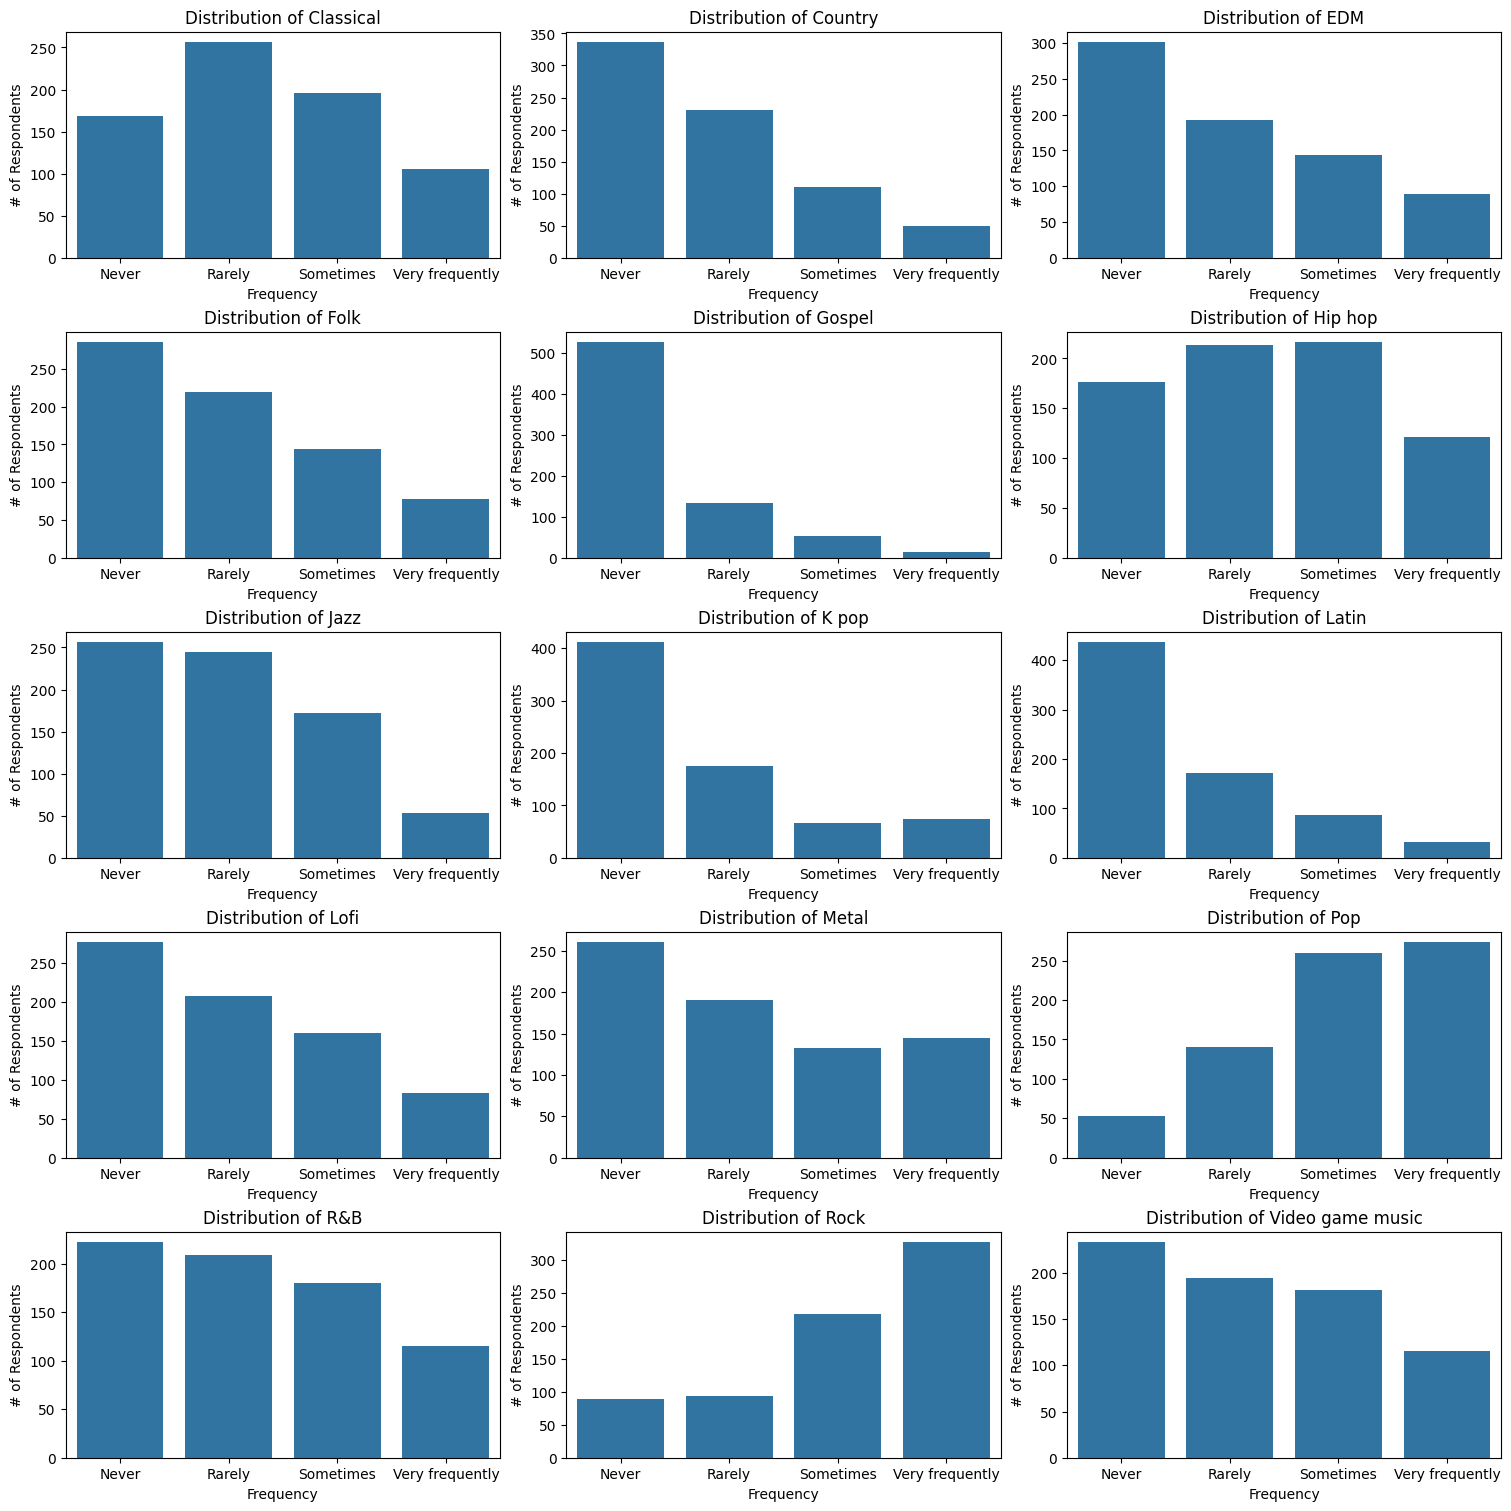

In [75]:
# Plot the distribution of each genre frequency in a grid
genre = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in genre:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [76]:
# Drop gospel and latin, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]', 'Frequency [Latin]'])

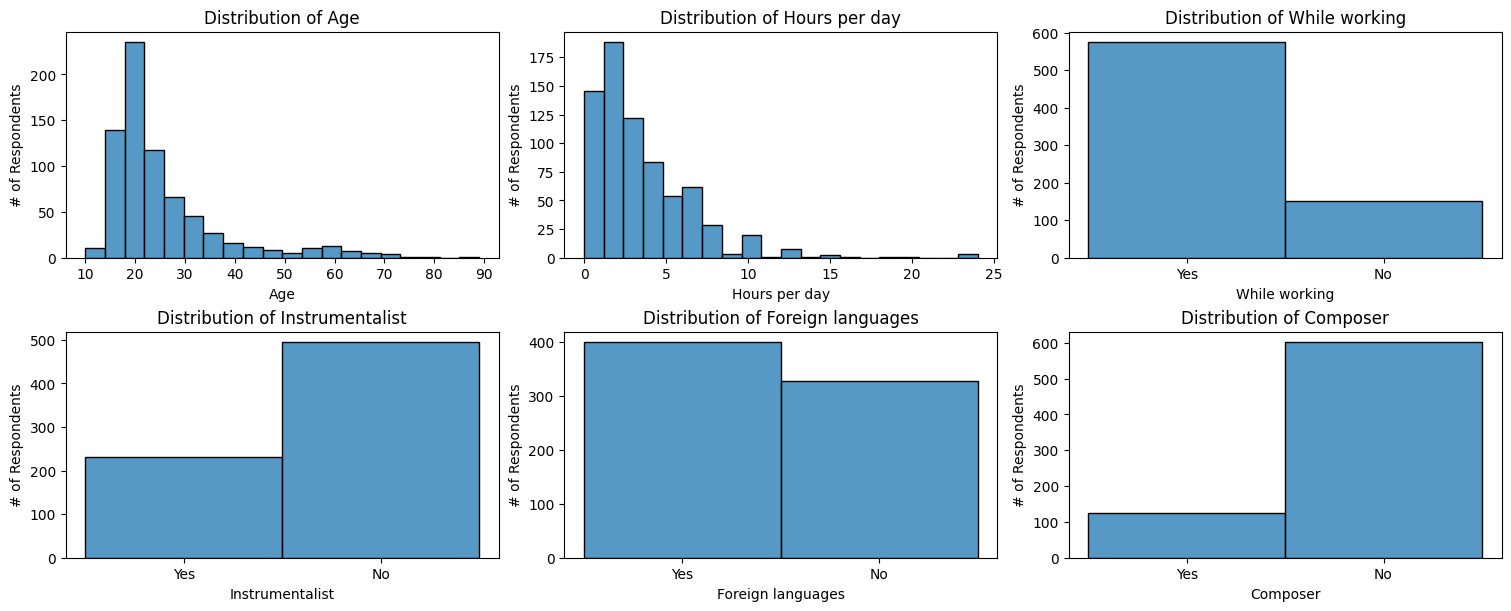

In [77]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

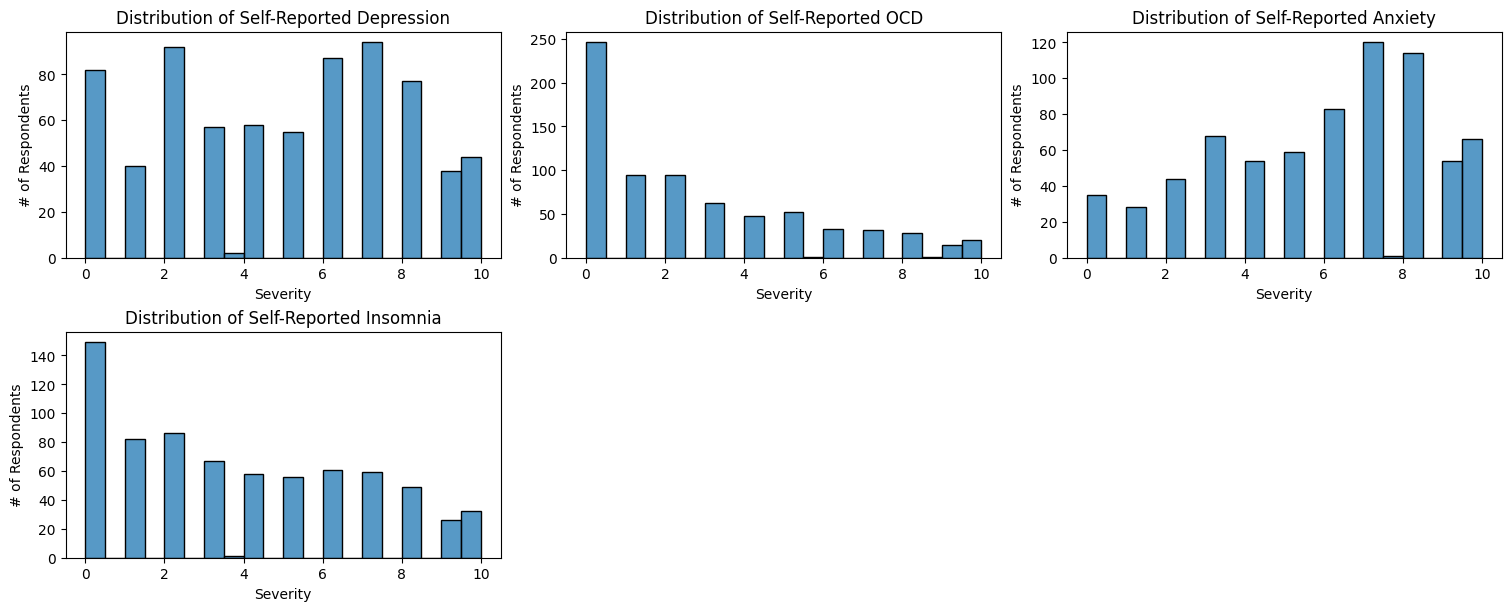

In [78]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [79]:
# Display summary statistics of the dataset
df.describe()

,Age,Hours per day,Anxiety,Depression,Insomnia,OCD
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,25.241047,3.564807,5.832645,4.803030,3.712810,2.629477
std,12.081723,3.006324,2.791839,3.027309,3.082849,2.845403
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,4.000000,2.000000,1.000000,0.000000
50%,21.000000,3.000000,6.000000,5.000000,3.000000,2.000000
75%,28.000000,5.000000,8.000000,7.000000,6.000000,4.000000
max,89.000000,24.000000,10.000000,10.000000,10.000000,10.000000


In [80]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [81]:
# Convert favourite genre into a boost applied to the users favourite genre frequency

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

fav_genre_boost = 1.0   # Boost amount 1.0 to add to favourite genre frequency

# Convert favourite genre into frequency column name
def convert_fav_genre_to_freq_col(genre):
    return f"Frequency [{genre}]"

# Apply boost to favourite genre frequency
for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + fav_genre_boost

# Drop original Fav genre column 
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [82]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# Identify Yes/No columns
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

# Conver true false to binary 1/0
for col in df_fe1.columns:
    if df_fe1[col].dtype == bool:
        df_fe1[col] = df_fe1[col].astype(int)

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe

# Save the final preprocessed dataframe to a new CSV file
processed_data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df_fe1.to_csv(processed_data_path, index=False)

# Print message to confirm saving
print(f"Processed data saved to {processed_data_path}")


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']
Processed data saved to c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\Data\mxmh_survey_results_processed.csv


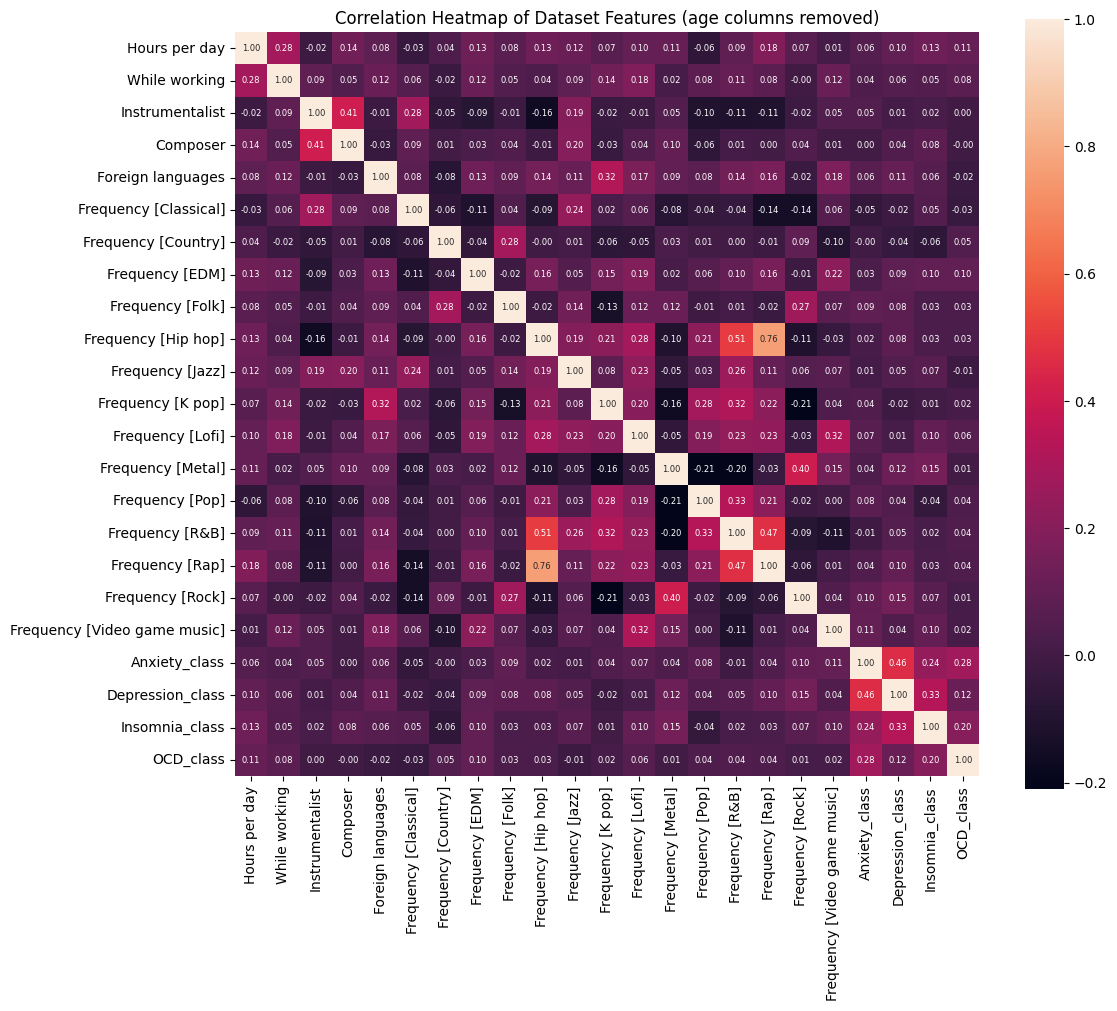

In [83]:
# Create a correlation heatmap for the dataset

# Drop any one-hot encoded AgeGroup columns so the matrix excludes age bins
age_cols = [c for c in df_fe1.columns if str(c).startswith('AgeGroup')]
if age_cols:
    corr_df = df_fe1.drop(columns=age_cols)
else:
    corr_df = df_fe1

corr = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size': 6}, square=True)
plt.title("Correlation Heatmap of Dataset Features (age columns removed)")
plt.show()

No individual correlations between genres and conditions can be observed here. However, we do notice a positive correlation between those who listen to Rap and Hip Hop, as well as Hip Hop and R&B.

Below we will conduct 3 experiments to investigate the correlation between music listening preferences/habits and mental health condition severity.

# 3. XGBoost Experiment

[I 2025-12-01 23:27:07,386] A new study created in memory with name: no-name-ec2e23f6-cd57-4c7b-b9bc-ad2b160b43a6
[I 2025-12-01 23:27:07,480] Trial 0 finished with value: 0.2961224161724561 and parameters: {'n_estimators': 101, 'learning_rate': 0.1487204030184981, 'max_depth': 4, 'subsample': 0.8287681833287943, 'colsample_bytree': 0.698528751018539, 'gamma': 1.9890674711621155, 'min_child_weight': 1}. Best is trial 0 with value: 0.2961224161724561.
[I 2025-12-01 23:27:07,631] Trial 1 finished with value: 0.3714359684187208 and parameters: {'n_estimators': 242, 'learning_rate': 0.18506631864692874, 'max_depth': 7, 'subsample': 0.835728305582957, 'colsample_bytree': 0.62679076847166, 'gamma': 0.9706083135838008, 'min_child_weight': 6}. Best is trial 1 with value: 0.3714359684187208.
[I 2025-12-01 23:27:07,862] Trial 2 finished with value: 0.3972983401648705 and parameters: {'n_estimators': 230, 'learning_rate': 0.08486238755226998, 'max_depth': 7, 'subsample': 0.9512329732475082, 'colsa

Best hyperparameters: {'n_estimators': 204, 'learning_rate': 0.19059965312081836, 'max_depth': 5, 'subsample': 0.9241294898581147, 'colsample_bytree': 0.8382597903731963, 'gamma': 0.34176820291888954, 'min_child_weight': 6}

Evaluation on test set:
Accuracy: 0.4794520547945205
Precision: 0.39631507775524005
Recall: 0.3951207243460764
F1 Score: 0.3770711500974659
ROC AUC: 0.5441277106231929

Classification report:
              precision    recall  f1-score   support

           0       0.34      0.29      0.31        35
           1       0.29      0.12      0.18        40
           2       0.55      0.77      0.64        71

    accuracy                           0.48       146
   macro avg       0.40      0.40      0.38       146
weighted avg       0.43      0.48      0.44       146



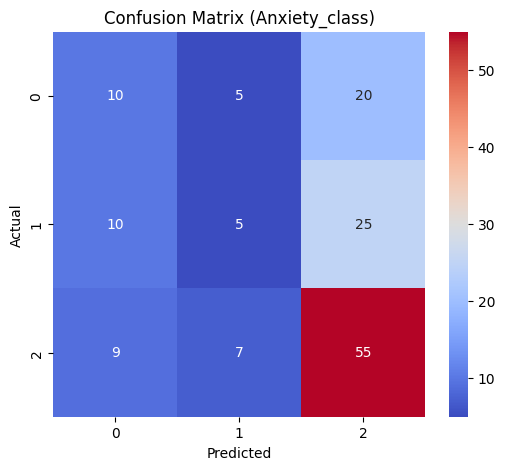

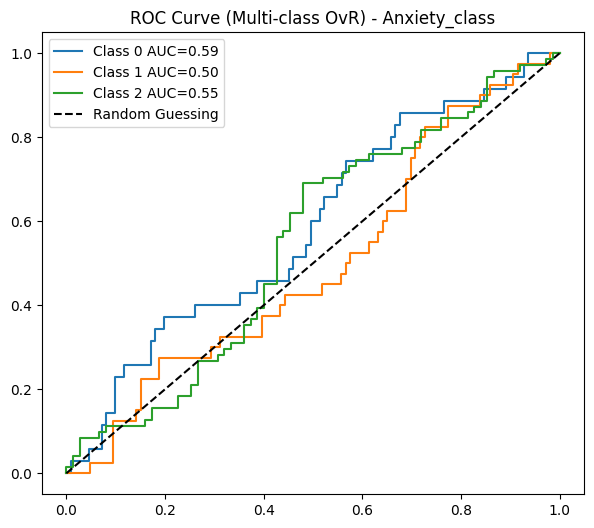

[I 2025-12-01 23:27:13,770] A new study created in memory with name: no-name-2ac41a81-1230-4eff-b4d3-dacccf7ae2b4


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 23:27:13,994] Trial 0 finished with value: 0.36031993974348525 and parameters: {'n_estimators': 373, 'learning_rate': 0.15829423727867908, 'max_depth': 4, 'subsample': 0.8942085698793705, 'colsample_bytree': 0.69565259975953, 'gamma': 0.6809345859851703, 'min_child_weight': 6}. Best is trial 0 with value: 0.36031993974348525.
[I 2025-12-01 23:27:14,176] Trial 1 finished with value: 0.3848468955054563 and parameters: {'n_estimators': 297, 'learning_rate': 0.1865495310945603, 'max_depth': 3, 'subsample': 0.8224534689096361, 'colsample_bytree': 0.726413562138242, 'gamma': 0.5797149462349733, 'min_child_weight': 2}. Best is trial 1 with value: 0.3848468955054563.
[I 2025-12-01 23:27:14,380] Trial 2 finished with value: 0.3778393031391167 and parameters: {'n_estimators': 326, 'learning_rate': 0.025695142555449843, 'max_depth': 3, 'subsample': 0.729589580492879, 'colsample_bytree': 0.8545117392592609, 'gamma': 1.4447008901596108, 'min_child_weight': 10}. Best is trial 1 with va

Best hyperparameters: {'n_estimators': 355, 'learning_rate': 0.10991973408219495, 'max_depth': 8, 'subsample': 0.7920716445625443, 'colsample_bytree': 0.8394947328270277, 'gamma': 0.9803251401323483, 'min_child_weight': 7}

Evaluation on test set:
Accuracy: 0.410958904109589
Precision: 0.3876167691957166
Recall: 0.39546911808987373
F1 Score: 0.3901416568083234
ROC AUC: 0.5910120965156603

Classification report:
              precision    recall  f1-score   support

           0       0.46      0.48      0.47        54
           1       0.24      0.20      0.22        41
           2       0.46      0.51      0.48        51

    accuracy                           0.41       146
   macro avg       0.39      0.40      0.39       146
weighted avg       0.40      0.41      0.40       146



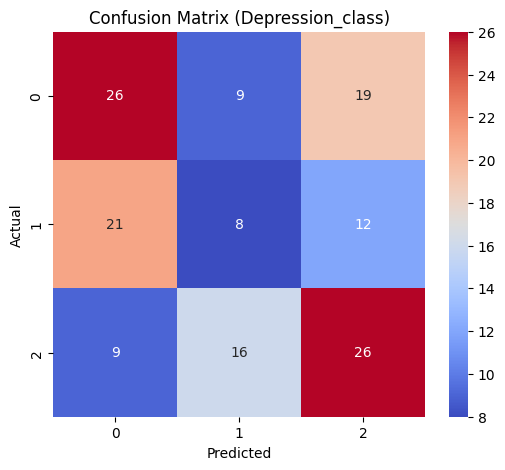

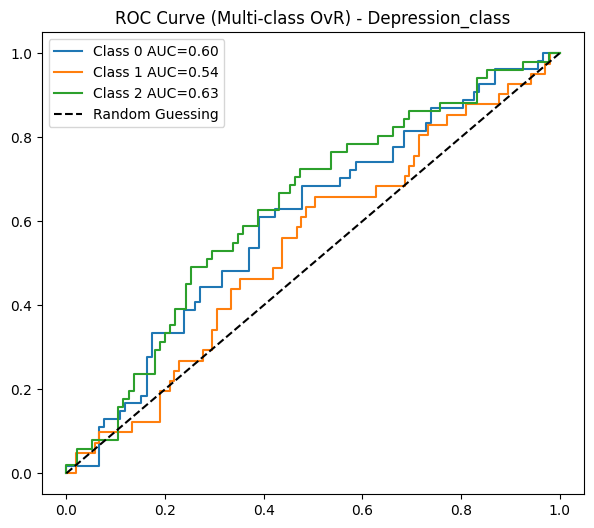

[I 2025-12-01 23:27:20,154] A new study created in memory with name: no-name-e181bdd5-9af0-48a4-9178-5182fd7bb269
[I 2025-12-01 23:27:20,346] Trial 0 finished with value: 0.3630343382178524 and parameters: {'n_estimators': 295, 'learning_rate': 0.10405952986657885, 'max_depth': 4, 'subsample': 0.846243031439652, 'colsample_bytree': 0.6693999659051929, 'gamma': 0.8466588310850534, 'min_child_weight': 8}. Best is trial 0 with value: 0.3630343382178524.


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_depression_model.pkl


[I 2025-12-01 23:27:20,712] Trial 1 finished with value: 0.360830737906553 and parameters: {'n_estimators': 366, 'learning_rate': 0.020594065631081737, 'max_depth': 6, 'subsample': 0.8547654062991199, 'colsample_bytree': 0.6179037355334879, 'gamma': 0.441622679231914, 'min_child_weight': 3}. Best is trial 0 with value: 0.3630343382178524.
[I 2025-12-01 23:27:21,145] Trial 2 finished with value: 0.3785227551206936 and parameters: {'n_estimators': 373, 'learning_rate': 0.03132624780778369, 'max_depth': 8, 'subsample': 0.8351985670471247, 'colsample_bytree': 0.9522851196129225, 'gamma': 0.24045236970453976, 'min_child_weight': 3}. Best is trial 2 with value: 0.3785227551206936.
[I 2025-12-01 23:27:21,279] Trial 3 finished with value: 0.3931472923907739 and parameters: {'n_estimators': 175, 'learning_rate': 0.15231457143309335, 'max_depth': 8, 'subsample': 0.9983491597789483, 'colsample_bytree': 0.8743455835248528, 'gamma': 0.2167772417966869, 'min_child_weight': 10}. Best is trial 3 with 

Best hyperparameters: {'n_estimators': 123, 'learning_rate': 0.05494931118380764, 'max_depth': 5, 'subsample': 0.9056098417095553, 'colsample_bytree': 0.8661824964719256, 'gamma': 0.24258694195905472, 'min_child_weight': 6}

Evaluation on test set:
Accuracy: 0.5
Precision: 0.3746879963694123
Recall: 0.36459836459836464
F1 Score: 0.34187625397726124
ROC AUC: 0.5456058690571964

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.83      0.67        77
           1       0.31      0.11      0.16        36
           2       0.25      0.15      0.19        33

    accuracy                           0.50       146
   macro avg       0.37      0.36      0.34       146
weighted avg       0.43      0.50      0.44       146



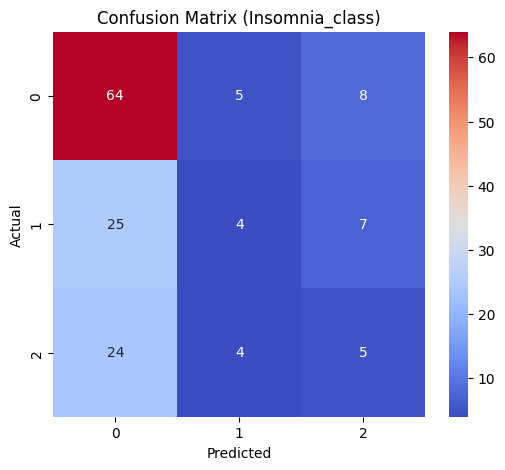

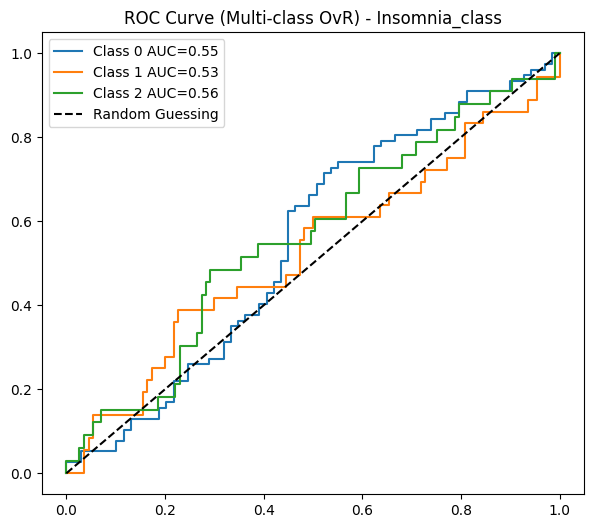

[I 2025-12-01 23:27:26,237] A new study created in memory with name: no-name-32c30182-69ce-4c4b-b70a-2d2ac862e6d8
[I 2025-12-01 23:27:26,413] Trial 0 finished with value: 0.30709122086244595 and parameters: {'n_estimators': 264, 'learning_rate': 0.21748518276433731, 'max_depth': 5, 'subsample': 0.7389845057244107, 'colsample_bytree': 0.6793288656605533, 'gamma': 1.0756548439714968, 'min_child_weight': 4}. Best is trial 0 with value: 0.30709122086244595.


Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_insomnia_model.pkl


[I 2025-12-01 23:27:26,596] Trial 1 finished with value: 0.2810117597557211 and parameters: {'n_estimators': 290, 'learning_rate': 0.04217551263273668, 'max_depth': 6, 'subsample': 0.91507590786922, 'colsample_bytree': 0.9855496526928188, 'gamma': 1.2532054806834065, 'min_child_weight': 4}. Best is trial 0 with value: 0.30709122086244595.
[I 2025-12-01 23:27:26,748] Trial 2 finished with value: 0.3114800993771556 and parameters: {'n_estimators': 231, 'learning_rate': 0.24843053136027726, 'max_depth': 4, 'subsample': 0.9366942455011995, 'colsample_bytree': 0.8525541670254402, 'gamma': 0.40905305258840996, 'min_child_weight': 5}. Best is trial 2 with value: 0.3114800993771556.
[I 2025-12-01 23:27:26,939] Trial 3 finished with value: 0.296109842484456 and parameters: {'n_estimators': 288, 'learning_rate': 0.09686583072344206, 'max_depth': 5, 'subsample': 0.8285227356540148, 'colsample_bytree': 0.890755787289385, 'gamma': 0.6698275150378423, 'min_child_weight': 1}. Best is trial 2 with val

Best hyperparameters: {'n_estimators': 111, 'learning_rate': 0.2437812345092707, 'max_depth': 8, 'subsample': 0.8691775337296146, 'colsample_bytree': 0.8018018898907211, 'gamma': 0.008054089835155195, 'min_child_weight': 10}

Evaluation on test set:
Accuracy: 0.6438356164383562
Precision: 0.40151515151515155
Recall: 0.3455685510071475
F1 Score: 0.32688500247483915
ROC AUC: 0.502961902406192

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       100
           1       0.18      0.07      0.11        27
           2       0.33      0.05      0.09        19

    accuracy                           0.64       146
   macro avg       0.40      0.35      0.33       146
weighted avg       0.55      0.64      0.57       146



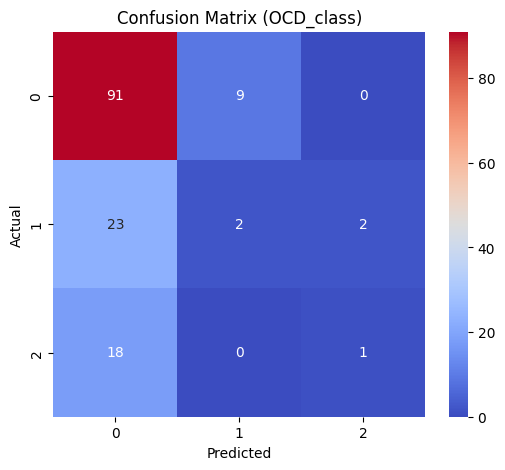

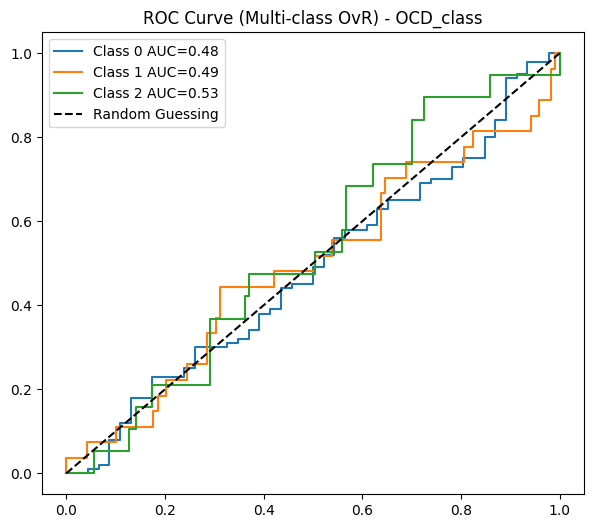

Saved model to: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [84]:
# Reusable training + optuna hyperparameter tuning function for any target (e.g., Anxiety_class, Depression_class, Insomnia_class, OCD_class)
# Optuna is a hyperparameter optimisation framework

# Define function to train, tune, evaluate, and save model
def train_and_eval(target_col, n_trials=50, random_state=42):
    
    # Prepare data based on target column
    if target_col not in df_fe1.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe.")

    # Exclude other target columns
    exclude_cols = [c for c in df_fe1.columns if c.endswith('_class')]

    # Prepare features and target
    X = df_fe1.copy().drop(columns=exclude_cols)
    y = df_fe1[target_col].copy()

    # Split data into 80% train and 20% test, stratified by target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Preprocessor (numeric features pipeline)
    num_features = X_train.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")), # Impute missing values with median
                ("scale", StandardScaler()) # Scale numeric features
            ]), num_features) # All features are numeric
        ]
    )

    # Optuna objective function, which trains and evaluates model with given hyperparameters
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "random_state": random_state,
            "n_jobs": 1
        }

        # Create XGBoost model with trial params
        model = XGBClassifier(**params) 

        # Build pipeline
        pipe = Pipeline([("prep", preprocessor), ("model", model)])

        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = [] # Collect F1 scores across folds

        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_val)
            score = f1_score(y_val, preds, average="macro")
            scores.append(score)
        return np.mean(scores) # Return average F1 score across folds

    # Create and optimise study to maximise F1 score by tuning hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Print best performing hyperparameters
    print("Best hyperparameters:", study.best_params)

    # Train final model with best params on full training set
    best_params = study.best_params
    final_model = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist", random_state=random_state, n_jobs=-1)
    final_pipe = Pipeline([("prep", preprocessor), ("model", final_model)])
    final_pipe.fit(X_train, y_train)

    # Evaluate on test set
    preds = final_pipe.predict(X_test)
    proba = final_pipe.predict_proba(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")
    try:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), proba, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    # Print evaluation results
    print("\nEvaluation on test set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({target_col})")
    plt.show()

    # Plot ROC curves if available
    if roc_auc is not None:
        plt.figure(figsize=(7,6))
        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        for i in range(proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
        plt.legend()
        plt.title(f"ROC Curve (Multi-class OvR) - {target_col}")
        plt.show()

    # Save model
    safe_name = target_col.replace('_class','').lower()
    model_path = os.path.join(os.path.dirname(current_dir), 'models', f'xgboost_{safe_name}_model.pkl')
    joblib.dump(final_pipe, model_path)
    print("Saved model to:", model_path)

    return {"target": target_col, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, "model_path": model_path}

# Run for both Anxiety and Depression (if available)
results = {}
for target in ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']:
    if target in df_fe1.columns:
        results[target] = train_and_eval(target, n_trials=30)
    else:
        print(f"Skipping {target}: column not present")


# 4. MLP Experiment



Training Times:
  MLP: 1268.92 ms

MLP Training Losses per epoch: [1.3195871114730835, 1.117950677871704, 1.089200735092163, 1.0512484312057495, 1.0695255994796753, 1.063218593597412, 1.068269968032837, 1.0124680995941162, 0.9937542676925659, 0.989332914352417]
MLP Validation Losses per epoch: [1.2545936107635498, 1.2473106384277344, 1.3542187213897705, 1.1410369873046875, 1.3100013732910156, 1.1716690063476562, 1.2271525859832764, 1.18328857421875, 1.2728112936019897, 1.161685585975647]
--- MLP Anxiety_class---
Test accuracy: 0.4315068493150685
Precision: 0.4395901282887584
Recall: 0.4315068493150685
F1 Score: 0.43502505996601415
Confusion Matrix:
 [[10  9 15]
 [ 7 14 16]
 [19 17 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.29      0.29        34
           1       0.35      0.38      0.36        37
           2       0.56      0.52      0.54        75

    accuracy                           0.43       146
   macro 

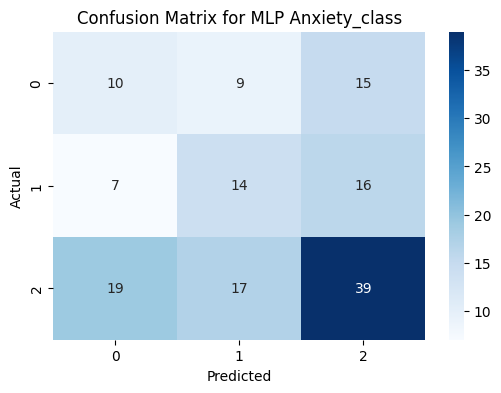

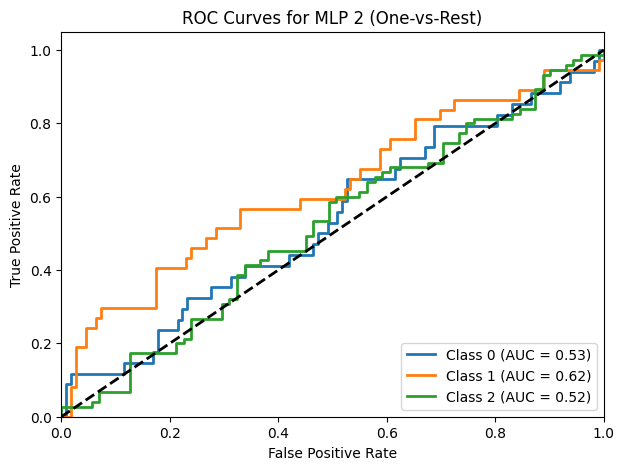


Test Times:
  MLP: 96.07 ms
Training Times:
  MLP: 1242.05 ms

MLP Training Losses per epoch: [1.4432088136672974, 1.1422806978225708, 1.1819607019424438, 1.1202706098556519, 1.114351749420166, 1.124171257019043, 1.0629658699035645, 1.032602071762085, 1.0561320781707764, 1.089522361755371]
MLP Validation Losses per epoch: [1.1300026178359985, 1.129410982131958, 1.1091011762619019, 1.1666611433029175, 1.113331913948059, 1.1165709495544434, 1.2431564331054688, 1.1163840293884277, 1.2433972358703613, 1.2270853519439697]
--- MLP Depression_class---
Test accuracy: 0.4315068493150685
Precision: 0.45107454834226723
Recall: 0.4315068493150685
F1 Score: 0.4052747431246538
Confusion Matrix:
 [[15 11 19]
 [ 5 10 35]
 [ 4  9 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.33      0.43        45
           1       0.33      0.20      0.25        50
           2       0.41      0.75      0.53        51

    accuracy                 

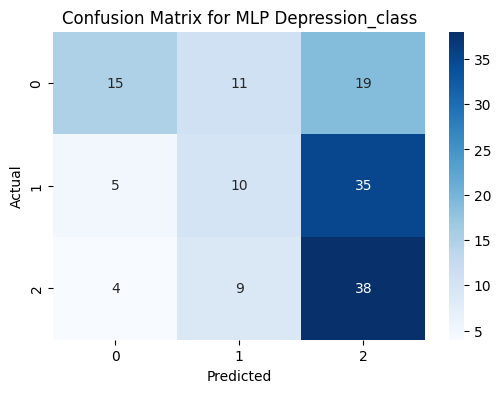

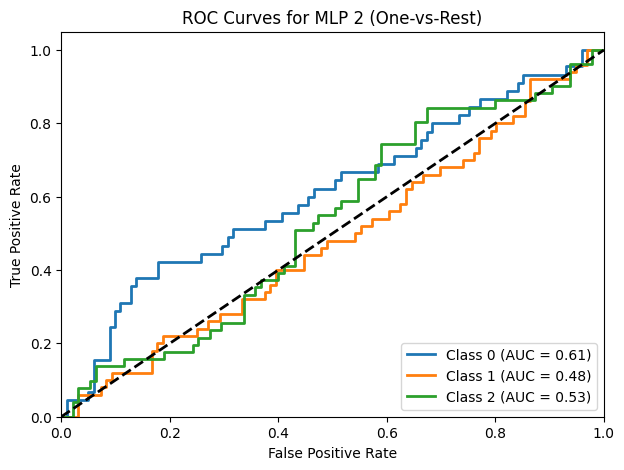


Test Times:
  MLP: 116.03 ms
Training Times:
  MLP: 1213.61 ms

MLP Training Losses per epoch: [1.3343095779418945, 1.103070616722107, 1.0865182876586914, 1.0617575645446777, 1.046787142753601, 1.0107821226119995, 1.0357552766799927, 1.0439831018447876, 0.9881922602653503, 1.0367186069488525]
MLP Validation Losses per epoch: [1.0574676990509033, 1.0337730646133423, 1.158294916152954, 1.0520014762878418, 1.0025240182876587, 1.0915732383728027, 1.043651819229126, 1.0192524194717407, 1.0478498935699463, 1.000779628753662]
--- MLP Insomnia_class---
Test accuracy: 0.4931506849315068
Precision: 0.30910128684101285
Recall: 0.4931506849315068
F1 Score: 0.37408134778939167
Confusion Matrix:
 [[71  2  6]
 [34  0  4]
 [27  1  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.90      0.67        79
           1       0.00      0.00      0.00        38
           2       0.09      0.03      0.05        29

    accuracy                

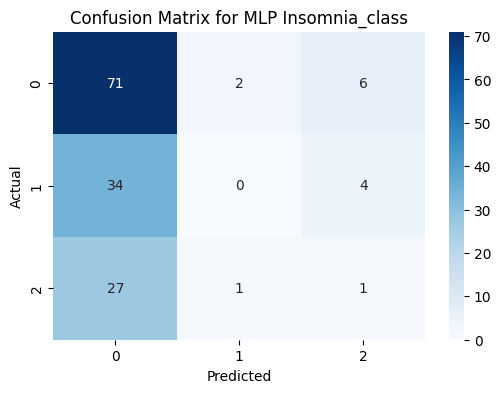

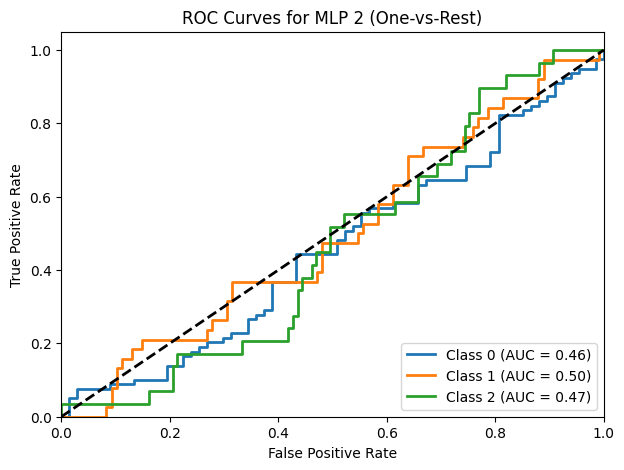


Test Times:
  MLP: 117.83 ms
Training Times:
  MLP: 1257.73 ms

MLP Training Losses per epoch: [1.0805245637893677, 0.9127689599990845, 0.8694286346435547, 0.8400188088417053, 0.8281598687171936, 0.8239803314208984, 0.814949095249176, 0.8015691637992859, 0.7897372841835022, 0.8285421133041382]
MLP Validation Losses per epoch: [0.8712733387947083, 0.8020522594451904, 0.8150016665458679, 0.8317579627037048, 0.78504878282547, 0.835597038269043, 0.7771685123443604, 0.7979442477226257, 0.8054895401000977, 0.9104311466217041]
--- MLP OCD_class---
Test accuracy: 0.5273972602739726
Precision: 0.5412553412089984
Recall: 0.5273972602739726
F1 Score: 0.49564047347800727
Confusion Matrix:
 [[67 22  2]
 [19  7  0]
 [23  3  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        91
           1       0.22      0.27      0.24        26
           2       0.60      0.10      0.18        29

    accuracy                     

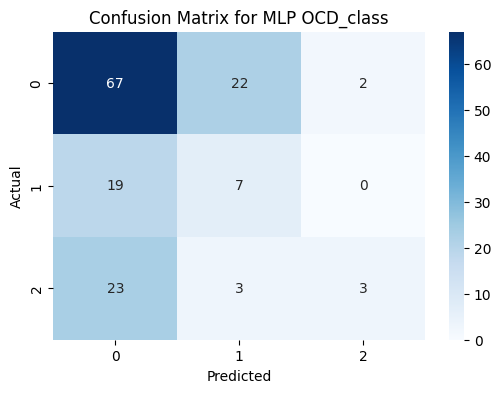

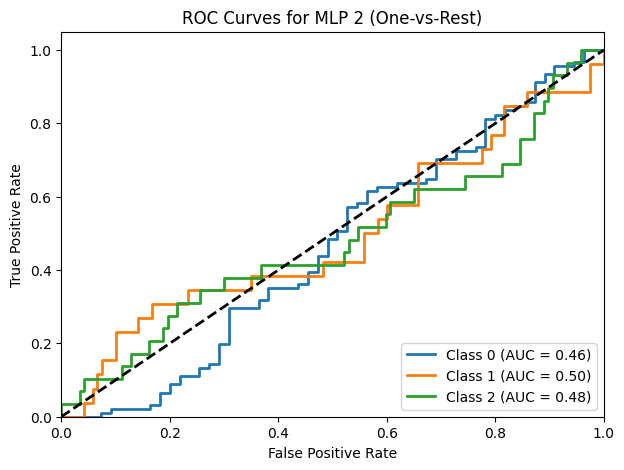


Test Times:
  MLP: 121.27 ms


In [85]:
# Looping the training for the model for each mental health class
classes = ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
for i in classes:
    X = df_fe1.drop(['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class'], axis = 1)
    y = df_fe1[i]

    # Split the data into train, validation and test and hold out 20% and 10% of observations as the validation and test set, respectively. Pass random_state=42.
    #First split 70% into train and then another 30% into temp
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    #Split the 30% into 20% for validation and 10% for testing
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

    training_times = {}
    mlp_train_losses = []
    mlp_val_losses = []

    #MLP
    mlp = Sequential()
    mlp.add(Dense(50, input_shape=(X_train.shape[1],), activation='tanh'))
    mlp.add(Dense(100, activation='tanh'))
    mlp.add(Dense(11, activation='softmax'))

    mlp.compile(
        optimizer=SGD(learning_rate=0.1),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    start_time = time.time()
    history_mlp = mlp.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=(X_val, y_val),
        verbose=0
    )

    end_time = time.time()
    training_times['MLP'] = (end_time - start_time) * 1000 # in milliseconds


    #Report the training time in milli second for all models.
    print("Training Times:")
    for model, t_time in training_times.items():
        print(f"  {model}: {t_time:.2f} ms")

    # These lists will be used in subsequent steps for plotting learning curves
    print("\nMLP Training Losses per epoch:", history_mlp.history['loss'])
    print("MLP Validation Losses per epoch:", history_mlp.history['val_loss'])

    y_test = np.round(y_test).astype(int)

    models = {
        'MLP': mlp
    }

    test_times = {}

    for model_name, model in models.items():
        start_test_time = time.time()

        y_test_pred_for_metrics = None
        y_score_for_roc = None
        
        # Keras models output probabilities directly when predict is called
        # for classification tasks with softmax activation.
        y_pred_proba_keras = model.predict(X_test, verbose=0)
        y_test_pred_for_metrics = np.argmax(y_pred_proba_keras, axis=1) # Convert probabilities to class labels
        y_score_for_roc = y_pred_proba_keras # Probabilities for ROC curve

        end_test_time = time.time()
        test_times[model_name] = (end_test_time - start_test_time) * 1000 # in milliseconds

        print(f"--- {model_name} {i}---")
        print("Test accuracy:", accuracy_score(y_test, y_test_pred_for_metrics))
        print("Precision:", precision_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Recall:", recall_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("F1 Score:", f1_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_for_metrics))
        print("Classification Report:\n", classification_report(y_test, y_test_pred_for_metrics))

        # ---- Confusion Matrix Plot ----
        cm = confusion_matrix(y_test, y_test_pred_for_metrics)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix for {model_name} {i}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Multiclass classification (One-vs-Rest)
        classes = np.unique(y_test)
        y_test_bin = label_binarize(y_test, classes=classes)
        n_classes = y_test_bin.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_for_roc[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(7, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                        lw=2,
                        label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {model_name} {i} (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()

    # Report the test time (in milli second) for all models.
    print("\nTest Times:")
    for model, t_time in test_times.items():
        print(f"  {model}: {t_time:.2f} ms")


# 5. Catboost Experiment

Generate unscaled version of the data for proper CatBoost training.
This keeps Age, Hours per day, and BPM as real interpretable values.

In [86]:
 
import pandas as pd
import numpy as np

print("="*70)
print("CREATING UNSCALED DATA FOR CATBOOST")
print("="*70)

# Load original data
df = pd.read_csv('../Data/mxmh_survey_results.csv')

print(f"\nOriginal data: {df.shape}")

# Drop irrelevant columns
df = df.drop(['Timestamp', 'Primary streaming service', 'Permissions', 
              'Music effects', 'Fav genre'], axis=1, errors='ignore')

# Drop rows with missing targets
df = df.dropna(subset=['Anxiety', 'Depression', 'Insomnia', 'OCD'])

# Remove BPM outlier
df = df[df['BPM'] < 1000]

print(f"After cleaning: {df.shape}")

# === ENCODE CATEGORICAL FEATURES (BUT DON'T SCALE NUMERIC) ===

# 1. Binary features: Yes/No → 1/0
binary_cols = ['While working', 'Instrumentalist', 'Composer', 
               'Exploratory', 'Foreign languages']

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
        print(f"Encoded {col}: Yes→1, No→0")

# 2. Frequency features: Never/Rarely/Sometimes/Very frequently → 0/1/2/3
frequency_cols = [col for col in df.columns if 'Frequency [' in col]

for col in frequency_cols:
    df[col] = df[col].map({
        'Never': 0,
        'Rarely': 1,
        'Sometimes': 2,
        'Very frequently': 3
    })

print(f"Encoded {len(frequency_cols)} genre frequency columns: 0-3 scale")

# 3. Fill any remaining missing values
for col in ['Age', 'Hours per day', 'BPM']:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# === REORDER COLUMNS ===
feature_cols = ['Age', 'Hours per day', 'BPM'] + binary_cols + frequency_cols
target_cols = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
df = df[feature_cols + target_cols]

# === SAVE ===
output_path = '../Data/listeningData_unscaled.csv'
df.to_csv(output_path, index=False)

print(f"\n✓ Saved to: {output_path}")
print(f"  Shape: {df.shape}")


CREATING UNSCALED DATA FOR CATBOOST

Original data: (736, 33)
After cleaning: (628, 28)
Encoded While working: Yes→1, No→0
Encoded Instrumentalist: Yes→1, No→0
Encoded Composer: Yes→1, No→0
Encoded Exploratory: Yes→1, No→0
Encoded Foreign languages: Yes→1, No→0
Encoded 16 genre frequency columns: 0-3 scale

✓ Saved to: ../Data/listeningData_unscaled.csv
  Shape: (628, 28)


CatBoost Models for Mental Health Prediction
Trains 4 models: Anxiety, Depression, Insomnia, OCD

In [87]:
"""
CatBoost Models for Mental Health Prediction
=============================================
Trains 4 models: Anxiety, Depression, Insomnia, OCD

Features:
- Feature engineering (genre aggregations)
- Condition-specific hyperparameters
- SmartBaselineModel wrapper for stable predictions
"""
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================
df = pd.read_csv("../Data/listeningData_unscaled.csv")

# Feature engineering
df_eng = df.copy()
genre_cols = [c for c in df.columns if c.startswith('Frequency')]
df_eng['Total_Genre_Engagement'] = df_eng[genre_cols].sum(axis=1)
df_eng['Genre_Diversity'] = (df_eng[genre_cols] >= 2).sum(axis=1)
heavy_genres = ['Frequency [Metal]', 'Frequency [Rock]', 'Frequency [Rap]', 'Frequency [Hip hop]']
df_eng['Heavy_Music_Preference'] = df_eng[heavy_genres].sum(axis=1)
calm_genres = ['Frequency [Classical]', 'Frequency [Jazz]', 'Frequency [Lofi]', 'Frequency [Folk]']
df_eng['Calm_Music_Preference'] = df_eng[calm_genres].sum(axis=1)

target_cols = ["Anxiety", "Depression", "Insomnia", "OCD"]
X = df_eng.drop(columns=target_cols)
X = X.fillna(X.median())
feature_names = X.columns.tolist()

print("="*70)
print("CATBOOST MODELS FOR MENTAL HEALTH PREDICTION")
print("="*70)
print(f"Dataset: {len(X)} samples, {len(feature_names)} features")

# ============================================================================
# SMART BASELINE MODEL
# ============================================================================
class SmartBaselineModel:
    """Wraps CatBoost with optimal blending between model and baseline predictions."""
    
    def __init__(self, catboost_params):
        self.catboost_params = catboost_params
        self.catboost = None
        self.mean_target = None
        self.blend_weight = 1.0
        self.feature_names = None
        
    def fit(self, X_train, y_train, X_val, y_val):
        self.mean_target = y_train.mean()
        self.feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else None
        
        self.catboost = CatBoostRegressor(
            **self.catboost_params,
            verbose=False,
            early_stopping_rounds=30
        )
        self.catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        
        cb_preds = self.catboost.predict(X_val)
        baseline_preds = np.full_like(y_val, self.mean_target)
        
        best_r2, best_weight = -999, 1.0
        for w in np.arange(0.0, 1.05, 0.05):
            blended = w * cb_preds + (1 - w) * baseline_preds
            r2 = r2_score(y_val, blended)
            if r2 > best_r2:
                best_r2, best_weight = r2, w
        
        self.blend_weight = best_weight
        
    def predict(self, X):
        cb_preds = self.catboost.predict(X)
        baseline_preds = np.full(len(X), self.mean_target)
        blended = self.blend_weight * cb_preds + (1 - self.blend_weight) * baseline_preds
        return np.clip(blended, 0, 10)
    
    def get_feature_importance(self):
        return self.catboost.get_feature_importance()

# ============================================================================
# TRAINING
# ============================================================================
params = {
    "Anxiety": {
        'iterations': 500, 'depth': 4, 'learning_rate': 0.05,
        'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'random_seed': 42
    },
    "Depression": {
        'iterations': 500, 'depth': 4, 'learning_rate': 0.03,
        'l2_leaf_reg': 5, 'loss_function': 'RMSE', 'random_seed': 42
    },
    "Insomnia": {
        'iterations': 300, 'depth': 3, 'learning_rate': 0.02,
        'l2_leaf_reg': 10, 'loss_function': 'RMSE', 'random_seed': 42
    },
    "OCD": {
        'iterations': 500, 'depth': 4, 'learning_rate': 0.03,
        'l2_leaf_reg': 5, 'loss_function': 'RMSE', 'random_seed': 42
    }
}

results = []

for condition in target_cols:
    print(f"\nTraining: {condition}")
    
    y = df_eng[condition]
    split_seed = 404 if condition == "Insomnia" else 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_seed)
    
    model = SmartBaselineModel(params[condition])
    model.fit(X_train, y_train, X_test, y_test)
    
    # Evaluate
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    importance = model.get_feature_importance()
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)
    top3 = feat_imp['Feature'].head(3).tolist()
    
    results.append({
        'Condition': condition,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'RMSE': test_rmse,
        'MAE': test_mae,
        'Top_Features': top3
    })
    
    # Save
    with open(f"catboost_{condition.lower()}.pkl", "wb") as f:
        pickle.dump(model, f)

# ============================================================================
# RESULTS
# ============================================================================
print("\n" + "="*70)
print("RESULTS")
print("="*70)
print(f"\n{'Condition':<12} {'Train R²':<10} {'Test R²':<10} {'RMSE':<8} {'MAE':<8} Top Features")
print("-" * 85)
for r in results:
    print(f"{r['Condition']:<12} {r['Train_R2']:<10.4f} {r['Test_R2']:<10.4f} {r['RMSE']:<8.3f} {r['MAE']:<8.3f} {r['Top_Features']}")

print("\n✓ Models saved to catboost_*.pkl")


CATBOOST MODELS FOR MENTAL HEALTH PREDICTION
Dataset: 628 samples, 28 features

Training: Anxiety

Training: Depression

Training: Insomnia

Training: OCD

RESULTS

Condition    Train R²   Test R²    RMSE     MAE      Top Features
-------------------------------------------------------------------------------------
Anxiety      0.2416     0.0758     2.654    2.183    ['Age', 'BPM', 'Frequency [Metal]']
Depression   0.2070     0.0329     2.945    2.534    ['Frequency [Metal]', 'Age', 'Heavy_Music_Preference']
Insomnia     0.1779     0.0440     3.131    2.769    ['Frequency [Metal]', 'Hours per day', 'Calm_Music_Preference']
OCD          0.1774     0.0302     2.770    2.265    ['Frequency [R&B]', 'Hours per day', 'Frequency [EDM]']

✓ Models saved to catboost_*.pkl


# 6. Genre Optimisation to Lessen Predicted Condition Severity

We have run experiments to predict mental health condition severity with XGBoost, Multi-Layer Perceptron, and CatBoost classifers and ackowledge that age, genre preferences, and genre listening habits are not sufficent to diagnose mental health disorders. Moreover, the models did not perform well enough to be used in a critical application such as mental disorder treatment.

Although we did use mental disorders as the target variable, our research was meant to investigate how genre preferences can impact mental health condition severity. To use our research for a real-world application that is not as critical as medical diagnosis, we have built a tool to suggest 3 genres for a user to listen to more frequently, and 3 to avoid in order to minimise the model's probability of predicting high condition severity.

The tool makes use of functions defined in the custom module 'FindingBestProfile2'. It takes in the user's listening profile and other features (excluding self reported mental health condition severity), as well as the condition they are wishing to improve. It utilises the optuna library, performing a study that uses Bayesian optimisation to vary genre listening frequency values across iterations, while fixing other user data, such as age and listening habits.

Here, we are demonstrating the optimiser tool being used on a random user from the original dataset to minimise their Depression severity. As the best performing model was the Depression XGBoost model, we will be using it in this demonstration.

In [88]:
import FindingBestProfile2 as fbp

In [89]:
# Load the dataset
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df = pd.read_csv(data_path)

In [90]:
# Resolve model file paths relative to the project root (parent of current working dir)
project_root = os.path.dirname(current_dir)
model_paths = {
    'anxiety': os.path.join(project_root, 'models', 'xgboost_anxiety_model.pkl'),
    'depression': os.path.join(project_root, 'models', 'xgboost_depression_model.pkl'),
    'insomnia': os.path.join(project_root, 'models', 'xgboost_insomnia_model.pkl'),
    'ocd': os.path.join(project_root, 'models', 'xgboost_ocd_model.pkl'),
}

# Display the keys of the model paths dictionary
print("Paths for:", model_paths.keys())

Paths for: dict_keys(['anxiety', 'depression', 'insomnia', 'ocd'])


In [91]:
# Initialise an object with a random user profile from the dataset for testing
random_user_profile = df.iloc[random.randint(0, len(df) - 1)]

# Build a feature vector compatible with the trained models.
# The training code used df_fe1 with all columns except those ending with '_class'
exclude_cols = [c for c in df.columns if c.endswith('_class')]
feature_cols = df.drop(columns=exclude_cols).columns

# Extract those features from the selected profile and convert to a 1-row DataFrame
features = random_user_profile[feature_cols].to_frame().T

# Display the features to verify
print("Selected profile index:", random_user_profile.name)
print("Feature columns used:", list(feature_cols))
features

Selected profile index: 410
Feature columns used: ['Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'AgeGroup_<18', 'AgeGroup_18-24', 'AgeGroup_25-34', 'AgeGroup_35-44', 'AgeGroup_45-54', 'AgeGroup_55-64', 'AgeGroup_65+']


,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Hip hop],...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],AgeGroup_<18,AgeGroup_18-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+
410,3.0,1.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,4.0,...,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Load the XGBoost models and store in a dictionary
loaded_model_dict = {}

# Load each model from its path
for cond, path in model_paths.items():
    full_path = os.path.abspath(path)
    loaded_model_dict[cond] = joblib.load(full_path)
    print(f"Loaded model for {cond}: {full_path}")

Loaded model for anxiety: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_anxiety_model.pkl
Loaded model for depression: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_depression_model.pkl
Loaded model for insomnia: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_insomnia_model.pkl
Loaded model for ocd: c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [93]:
# Optimise music genre profile for depression condition
best_profile, try_genres, avoid_genres = fbp.optimise_genre_profile(
    user_profile=features.iloc[0],
    condition='depression',
    model_dict=loaded_model_dict,
    n_trials=100
)

[I 2025-12-01 23:27:38,640] A new study created in memory with name: no-name-fcfe7aa8-8964-437a-9a64-8ae093fb986d
[I 2025-12-01 23:27:38,652] Trial 0 finished with value: 0.17534774541854858 and parameters: {'max_genre': 'Frequency [Pop]', 'Frequency [Classical]': 2.9382428568780496, 'Frequency [Country]': 1.0143197928847727, 'Frequency [EDM]': 1.011361841212554, 'Frequency [Folk]': 2.6407138424525027, 'Frequency [Hip hop]': 1.382100349281452, 'Frequency [Jazz]': 2.023708373326382, 'Frequency [K pop]': 3.0155330339392648, 'Frequency [Lofi]': 2.8342685799412415, 'Frequency [Metal]': 2.3232767110138077, 'Frequency [R&B]': 3.449445700430453, 'Frequency [Rap]': 2.189959254900485, 'Frequency [Rock]': 1.0865446338572875, 'Frequency [Video game music]': 2.7491199989844404}. Best is trial 0 with value: 0.17534774541854858.
[I 2025-12-01 23:27:38,663] Trial 1 finished with value: 0.28075411915779114 and parameters: {'max_genre': 'Frequency [Classical]', 'Frequency [Country]': 3.1163231352911125

In [94]:
# To display the results
print("Try genres:", try_genres)
print("Avoid genres:", avoid_genres)

Try genres: ['Frequency [EDM]', 'Frequency [K pop]', 'Frequency [Hip hop]']
Avoid genres: ['Frequency [Rock]', 'Frequency [Lofi]', 'Frequency [Video game music]']
